In [180]:
import pandas as pd
# Data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import json
import numpy as np

### Functions

In [6]:
def extract_value_from_dict(df, colname, val_pos):
    df_temp = pd.json_normalize(df[colname])
    df_temp = df_temp.applymap(lambda x: list(x.values())[val_pos] if isinstance(x, dict) else x)
    df_temp.columns = [f"{colname}_{x}" for x in df_temp.columns]
    df = df.drop(colname, axis=1)
    return pd.concat([df, df_temp], axis=1)

In [20]:
def extract_values(series, key):
    def extract(row):
        values = []
        for d in row:
            if key in d:
                values.append(d[key])
        return values
    return series.apply(extract)

# Loading data

In [134]:
with open('./../data/dumps/maldita.json', 'r') as f:
    json_iberifier = json.load(f)
df_iberifier = pd.json_normalize(json_iberifier)
df_iberifier['formats'] = extract_values(df_iberifier['formats'], 'name')
df_iberifier['sources'] = extract_values(df_iberifier['sources'], 'name')
df_iberifier['categories'] = extract_values(df_iberifier['categories'], 'name')

# Drop unused columns
to_drop = ['organization.id', 'debunkContent', 'media', 'keywords', 'organizationCalification.calification.id']
for col in to_drop:
    df_iberifier = df_iberifier.drop(col, axis=1)
    
# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'fact_id', 
               'type.name': 'type',
               'organization.name': 'fact-checker',
               'organizationCalification.calification.explanation': 'explanation', 
               'organizationCalification.calification.name': 'veracity',
               'date.$date': 'date'}
df_iberifier = df_iberifier.rename(columns=rename_cols)

# Convert datetime object
df_iberifier['date'] = df_iberifier['date'].astype('datetime64[ns]') 

df_iberifier.head(1)

,text,content,formats,createdAt,sources,categories,link,fact_id,type,fact-checker,veracity,explanation,date
0,"No, esta agresión a un médico que atiende a un...","España, cada vez más frecuentes los ataques a ...",[Vídeo],2023-03-08T09:11:42+01:00,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",https://maldita.es/malditobulo/20230308/agresi...,6409218c5966ae90e851a389,Otros / Outros,Maldita.es,Falso,Se ha contrastado de forma independiente que e...,2023-03-08 08:11:42


In [54]:
with open('./../data/dumps/tweets.json', 'r') as f:
    json_tweets = json.load(f)
df_tweets = pd.json_normalize(json_tweets)
df_tweets['fact_id'] = extract_values(df_tweets['fact_id'], '$oid')

# Drop unused columns
to_drop = ['tweet.in_reply_to_user.withheld.scope', 'tweet.withheld.scope', 'tweet.attachments.poll_ids', 'tweet.author.withheld.scope']
for col in to_drop:
    df_tweets = df_tweets.drop(col, axis=1)

# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'tweet.public_metrics.retweet_count': 'retweet_count',
               'tweet.public_metrics.like_count': 'like_count',
               'tweet.public_metrics.quote_count': 'quote_count',
               'tweet.public_metrics.impression_count': 'impression_count'
              }

df_tweets = df_tweets.rename(columns=rename_cols)

# Convert datetime object
df_tweets['date'] = df_tweets['date'].astype('datetime64[ns]') 

df_tweets.head(1)

,tweet_id,fact_id,text,db_id,date,retweet_count,tweet.public_metrics.reply_count,like_count,quote_count,impression_count,...,tweet.in_reply_to_user.username,tweet.in_reply_to_user.location,tweet.in_reply_to_user.id,tweet.in_reply_to_user.name,tweet.attachments.media_keys,tweet.attachments.media,tweet.withheld.copyright,tweet.withheld.country_codes,tweet.author.withheld.country_codes,tweet.in_reply_to_user.withheld.country_codes
0,1631080654195572736,[6409218c5966ae90e851a389],"@wallstwolverine No sé, aquí hay mitad y mitad...",6413ae166fa02fd2fb322358,2023-03-01 23:55:06,0,0,0,0,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
with open('./../data/dumps/mynews.json', 'r') as f:
    json_mynews = json.load(f)
df_mynews = pd.json_normalize(json_mynews)


# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'fact_id.$oid': 'fact_id'
              }

df_mynews = df_mynews.rename(columns=rename_cols)

# Convert datetime object
df_mynews['date'] = df_mynews['date'].astype('datetime64[ns]') 

df_mynews.head(1)

,IdDocument,Title,Section,Date,Author,Newspaper,Subtitle,Page,Content,GeneralReference,...,Groups,Diffusion,Value,Audience,Logo,Ref,query_output,db_id,fact_id,date
0,00001416-20230302-000323,TOM BJOERKLUND Diseñar una construcción par...,MISCELANEA CIENCIA,02/03/2023,,El Mundo Andalucía,,AA043,"[2651 Caracteres]TOM BJOERKLUND ""Diseñar una ...",El Mundo 02-03-23,...,"[[52], [37], [35], [17], [13]]",5807.0,883.993423,90000.0,/media/logos/EMA1.gif,1416,2765,6413ae8bde7d0add923cb1df,6409218c5966ae90e851a389,2023-03-02


## Time period

In [62]:
print(f" First day for Maldita: {min(df_iberifier['date'])}")
print(f" Last day for Maldita: {max(df_iberifier['date'])}")
print(f" Lenght period for Maldita: {max(df_iberifier['date']) - min(df_iberifier['date']) }")

 First day for Maldita: 2023-03-08 08:11:42
 Last day for Maldita: 2023-04-05 15:28:33
 Lenght period for Maldita: 28 days 07:16:51


In [63]:
print(f" First day for Twitter: {min(df_tweets['date'])}")
print(f" Last day for Twitter: {max(df_tweets['date'])}")
print(f" Lenght period for Twitter: {max(df_tweets['date']) - min(df_tweets['date']) }")

 First day for Twitter: 2023-03-01 00:05:45
 Last day for Twitter: 2023-04-12 23:57:19
 Lenght period for Twitter: 42 days 23:51:34


In [64]:
print(f" First day for MyNews: {min(df_mynews['date'])}")
print(f" Last day for MyNews: {max(df_mynews['date'])}")
print(f" Lenght period for MyNews: {max(df_mynews['date']) - min(df_mynews['date']) }")

 First day for MyNews: 2023-03-02 00:00:00
 Last day for MyNews: 2023-04-12 00:00:00
 Lenght period for MyNews: 41 days 00:00:00


## Per claims

In [90]:
# Tweets
# Need to explode the list in fact_id before groupby
df_exploded = df_tweets.explode('fact_id')
tweets_grouped = df_exploded.groupby('fact_id').size()#.mean()
#sns.violinplot(data=tweets_grouped, inner='points', cut=0)

# For mynews
mynews_grouped = df_mynews.groupby('fact_id').size()
mynews_grouped

# Concat
count_per_claim = pd.concat([tweets_grouped, mynews_grouped], axis=1, keys=['count_tweets', 'count_articles']).reset_index()
count_per_claim = count_per_claim.fillna(0)
count_per_claim['count_tweets'] = count_per_claim['count_tweets'].astype('int') 
count_per_claim['count_articles'] = count_per_claim['count_articles'].astype('int') 
count_per_claim

fact_id
6409218c5966ae90e851a389    134
640bc48c12b81f6047a2e4e1     93
640bc48c12b81f6047a2e4e2    130
640bc48c12b81f6047a2e4e3    137
640bc48c12b81f6047a2e4e4    113
                           ... 
642e0b8cf510dcaa70adbe3c    140
642e0b8cf510dcaa70adbe3d    107
642e0b8cf510dcaa70adbe3e    139
642e0b8cf510dcaa70adbe40    136
642e0b8cf510dcaa70adbe42    131
Length: 92, dtype: int64

<AxesSubplot: ylabel='Count'>

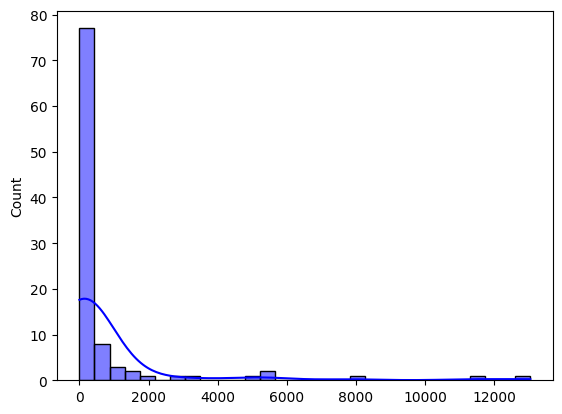

In [111]:
sns.histplot(tweets_grouped, kde=True, color='blue', bins=30)

<AxesSubplot: ylabel='Count'>

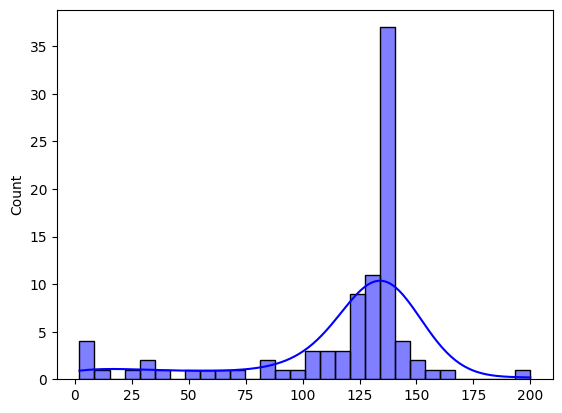

In [112]:
sns.histplot(mynews_grouped, kde=True, color='blue', bins=30)

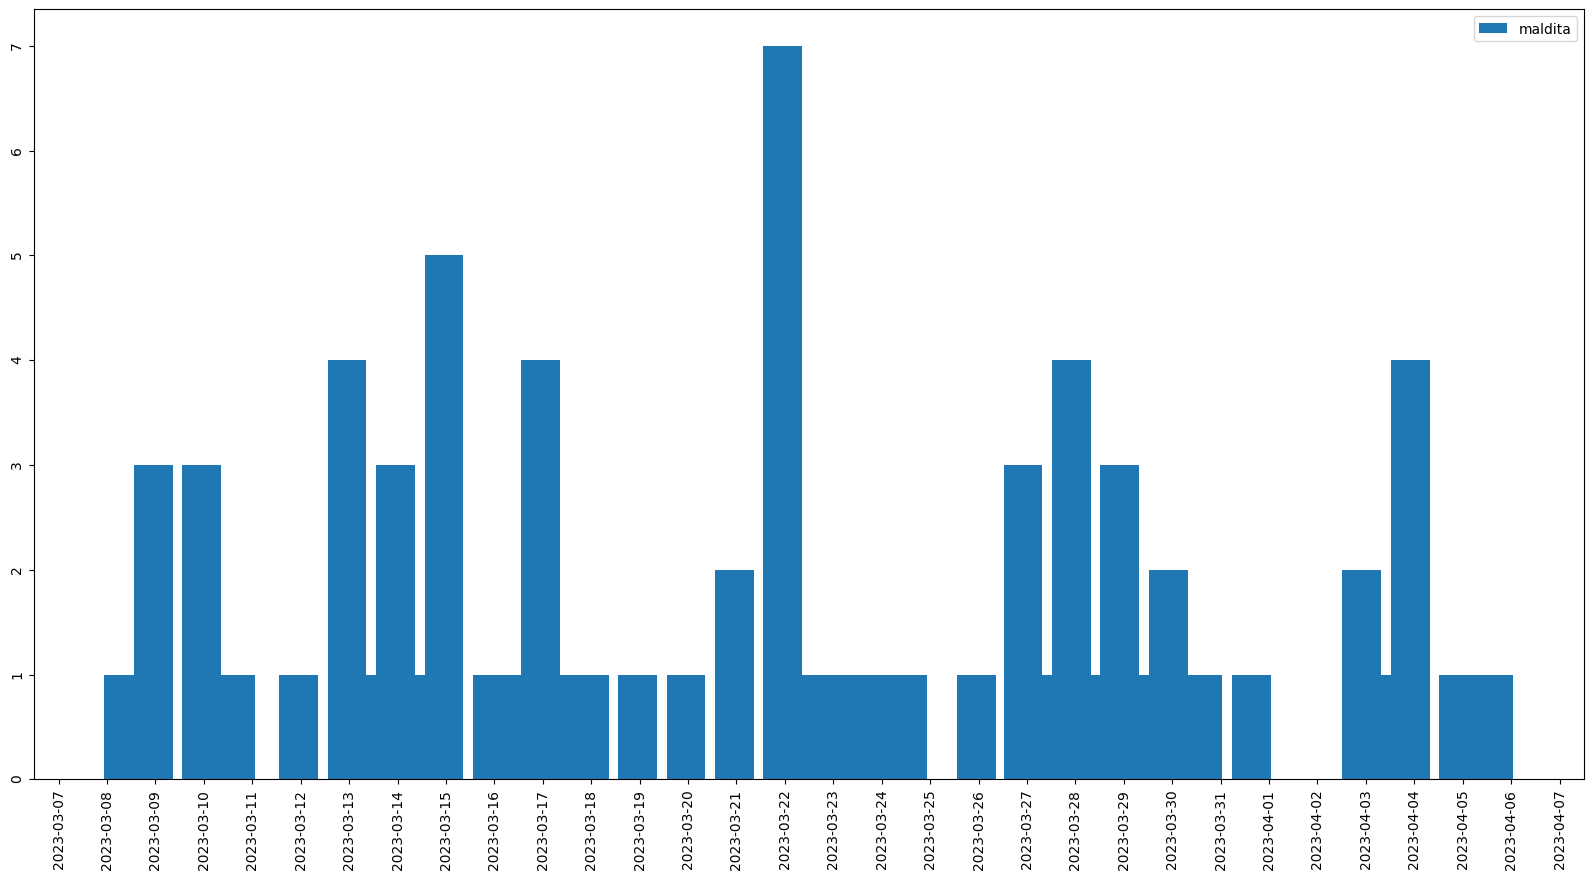

In [121]:
iberifier_dates = df_iberifier.groupby(df_iberifier['date']).size()
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(iberifier_dates.index, iberifier_dates.values, label='maldita')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.tick_params(rotation=90)
ax.legend()
plt.show()

In [ ]:
tweets = df_tweets.groupby(df_tweets['date'])['count'].sum()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(tweets.index, tweets.values, '--')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.tick_params(rotation=90)
plt.show()

In [ ]:
mynews = df_mynews.groupby(df_mynews['date'])['count'].sum()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(mynews.index, mynews.values, '--')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.tick_params(rotation=90)
plt.show()

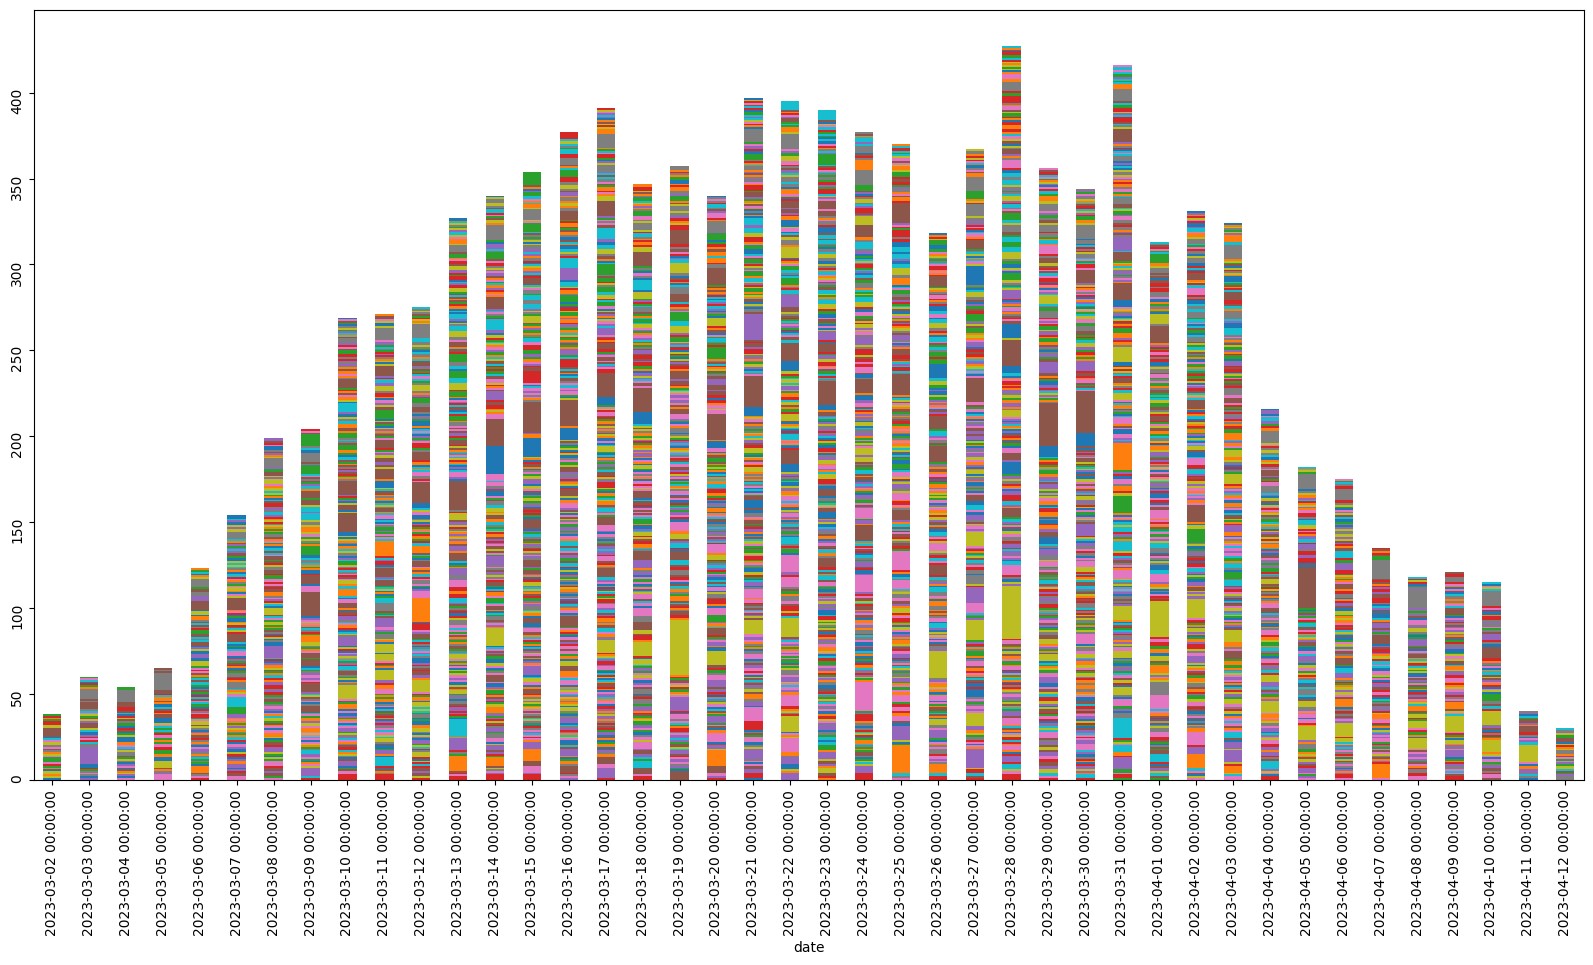

In [124]:
fig, ax = plt.subplots(figsize=(20, 10))
df_mynews.groupby([df_mynews['date'], df_mynews['Newspaper']]).size().unstack().plot.bar(stacked=True, 
                                                                                                 ax=ax, legend=False)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.tick_params(rotation=90)
plt.show()

## Newspaper parsed

In [67]:
unique_newspapers = df_mynews['Newspaper'].unique().size
unique_newspapers

2142

<AxesSubplot: >

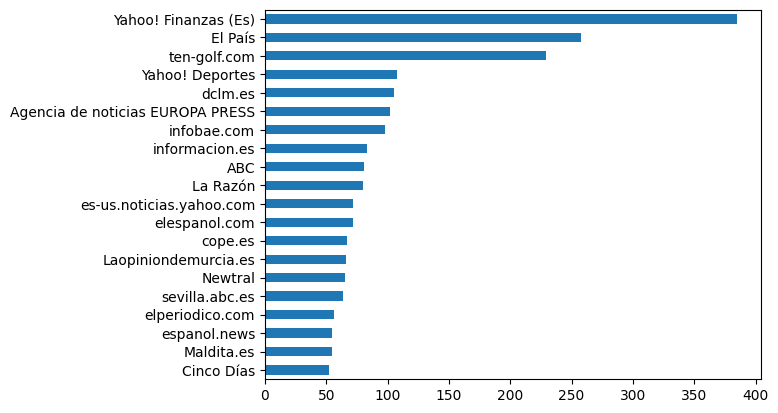

In [98]:
df_mynews['Newspaper'].value_counts(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')

/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


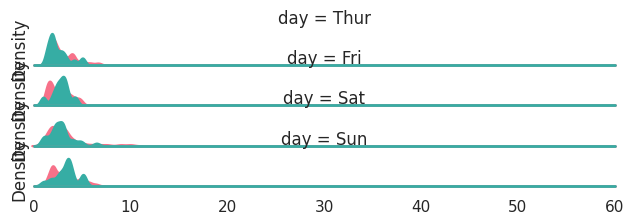

In [145]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


# Impact of fact check

In [181]:
# Explode tweets on fact_id list
tweets_exploded = df_tweets.explode('fact_id')
tweets_exploded

# Merge the iberifier onto the tweets based on the fact_id
tweets_iberifier = pd.merge(tweets_exploded, df_iberifier[['date', 'sources', 'fact_id', 'categories', 'type', 'fact-checker', 'veracity']], on='fact_id', how='left')

# Rename the date to avoid confusion
tweets_iberifier = tweets_iberifier.rename(columns={'date_x': 'date_tweet', 'date_y': 'date_fact_check'})

# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_iberifier['diff_date'] = (tweets_iberifier['date_tweet'] - tweets_iberifier['date_fact_check']).dt.days
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].fillna(0)
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].astype('int') 
tweets_iberifier['impact'] = np.where(tweets_iberifier['diff_date'] <0, 'Before', np.where(tweets_iberifier['diff_date'] >0, 'After', 0))

<AxesSubplot: xlabel='diff_date', ylabel='0'>

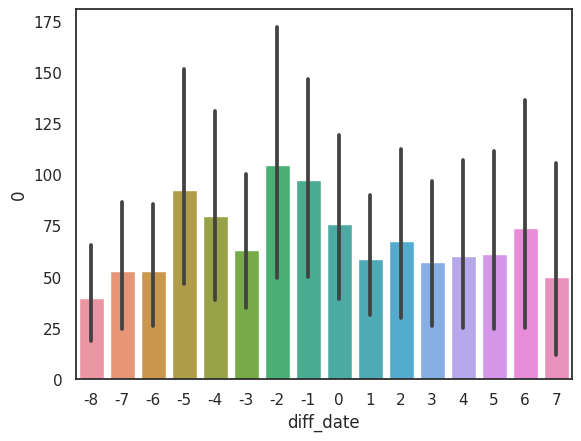

In [178]:
diff_date = tweets_iberifier.groupby(['fact_id', 'diff_date']).size().reset_index()[['diff_date', 0]]
sns.barplot(diff_date, x='diff_date', y=0)

In [203]:
tweets_iberifier

,tweet_id,fact_id,text,db_id,date_tweet,retweet_count,tweet.public_metrics.reply_count,like_count,quote_count,impression_count,...,tweet.author.withheld.country_codes,tweet.in_reply_to_user.withheld.country_codes,date_fact_check,sources,categories,type,fact-checker,veracity,diff_date,impact
0,1631080654195572736,6409218c5966ae90e851a389,"@wallstwolverine No sé, aquí hay mitad y mitad...",6413ae166fa02fd2fb322358,2023-03-01 23:55:06,0,0,0,0,50,...,NaN,NaN,2023-03-08 08:11:42,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",Otros / Outros,Maldita.es,Falso,-7,Before
1,1631079144543879174,6409218c5966ae90e851a389,@Chileokulto No voy a justificar nada! Hay un ...,6413ae166fa02fd2fb32235a,2023-03-01 23:49:06,0,0,2,0,43,...,NaN,NaN,2023-03-08 08:11:42,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",Otros / Outros,Maldita.es,Falso,-7,Before
2,1631078102196535297,6409218c5966ae90e851a389,"Son capaces de decir, a la vez, que la densida...",6413ae166fa02fd2fb32235c,2023-03-01 23:44:58,0,1,7,0,435,...,NaN,NaN,2023-03-08 08:11:42,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",Otros / Outros,Maldita.es,Falso,-7,Before
3,1631070900580765699,6409218c5966ae90e851a389,💙🤍25min Que hay que ver \nHermano @alexsanchez...,6413ae166fa02fd2fb32235e,2023-03-01 23:16:21,0,0,1,0,414,...,NaN,NaN,2023-03-08 08:11:42,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",Otros / Outros,Maldita.es,Falso,-7,Before
4,1631070104866762752,6409218c5966ae90e851a389,NO HAY NI UNA SOLA VEZ QUE EL CARTEL DEL PP NO...,6413ae166fa02fd2fb322360,2023-03-01 23:13:11,1,0,1,0,4,...,NaN,NaN,2023-03-08 08:11:42,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",Otros / Outros,Maldita.es,Falso,-7,Before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72662,1646074383000059904,642e0b8cf510dcaa70adbe42,@veintimillapier Como muchas otras mentiras y ...,6438983e6fa02fd2fb55c3f7,2023-04-12 08:54:50,0,0,1,0,11,...,NaN,NaN,2023-04-05 15:28:33,[Facebook],[Política],Contexto falso - Información / Informação falsa,Maldita.es,Falso,6,After
72663,1646039643379445761,642e0b8cf510dcaa70adbe42,"◾Macron está de visita en los Países Bajos, do...",6438983e6fa02fd2fb55c3f9,2023-04-12 06:36:47,0,1,1,0,67,...,NaN,NaN,2023-04-05 15:28:33,[Facebook],[Política],Contexto falso - Información / Informação falsa,Maldita.es,Falso,6,After
72664,1646016669238566912,642e0b8cf510dcaa70adbe42,En lugar de andar pagando para dar conciertos ...,6438983e6fa02fd2fb55c3fb,2023-04-12 05:05:30,3,3,11,0,458,...,NaN,NaN,2023-04-05 15:28:33,[Facebook],[Política],Contexto falso - Información / Informação falsa,Maldita.es,Falso,6,After
72665,1645958673821315074,642e0b8cf510dcaa70adbe42,"Refugiado del gobierno de #Belgica, con estatu...",6438983e6fa02fd2fb55c3fd,2023-04-12 01:15:02,0,0,0,0,8,...,NaN,NaN,2023-04-05 15:28:33,[Facebook],[Política],Contexto falso - Información / Informação falsa,Maldita.es,Falso,6,After


<AxesSubplot: xlabel='impact', ylabel='0'>

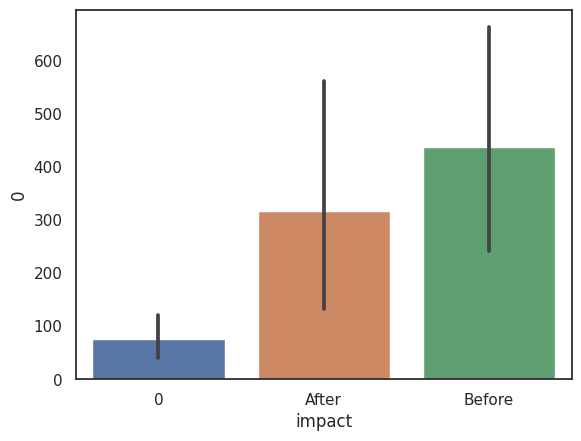

In [192]:
diff_date = tweets_iberifier.groupby(['fact_id', 'impact']).size().reset_index()[['impact', 0]]
sns.barplot(diff_date, x='impact', y=0)

In [204]:
fact_checker_size = tweets_iberifier.groupby(['fact-checker', 'date_tweet']).size().reset_index()
fact_checker_size = fact_checker_size.rename(columns={0: 'count'})